In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Build your own convolutional neural network using pytorch

In [1]:
import os
import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report


In [25]:
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvNeuralNetwork, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels= 128, out_channels= 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels= 256, out_channels=512, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=128 * 9 * 9  , out_features= 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256, out_features=3)

        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.classifier(x)
        return x


In [26]:
torch.manual_seed(42)
model = ConvNeuralNetwork()
model

ConvNeuralNetwork(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil

In [27]:
random_tensor = torch.randn(1,3, 75, 75)
model(random_tensor)

tensor([[-0.1087,  0.2088,  0.1392]], grad_fn=<AddmmBackward0>)

# 2. Train your model using dog heart dataset (you may need to use  Google Colab (or Kaggle) with GPU to train your code)

### (1) use torchvision.datasets.ImageFolder for the training dataset
### (2) use custom dataloader for test dataset (return image tensor and file name)

In [28]:

transform = transforms.Compose([
    transforms.Resize((75, 75)),
    transforms.ToTensor()
])

In [29]:
#Image loader

#Loading data
train_data = ImageFolder('/kaggle/input/dog-dataset/Dog_heart/Dog_heart/Train', transform=transform)
valid_data = ImageFolder('/kaggle/input/dog-dataset/Dog_heart/Dog_heart/Valid', transform=transform)
test_data = ImageFolder('/kaggle/input/dog-dataset/Test', transform=transform)

In [30]:
train_data.find_classes('/kaggle/input/dog-dataset/Dog_heart/Dog_heart/Train')

(['Large', 'Normal', 'Small'], {'Large': 0, 'Normal': 1, 'Small': 2})

In [31]:
train_data[0][0].unsqueeze(0).shape

torch.Size([1, 3, 75, 75])

In [32]:
train_data_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_data_loader = DataLoader(valid_data, batch_size=32, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=1, shuffle=False)

print(f"Length of train dataloader: {len(train_data_loader)} batches of {32}")
print(f"Length of Valid dataloader: {len(valid_data_loader)} batches of {32}")
print(f"Length of test dataloader: {len(test_data_loader)} batches of {1}")

Length of train dataloader: 44 batches of 32
Length of Valid dataloader: 7 batches of 32
Length of test dataloader: 400 batches of 1


In [33]:
device ="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Setup loss fn and optimizer

In [35]:
accuracy_function = Accuracy(task='multiclass', num_classes= 3).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.0001)

In [36]:
# training the model
torch.manual_seed(42)
def train_step(model, train_data_loader, accuracy_function, loss_function, optimizer, device):
    model.train()
    model.to(device)
    train_loss = 0
    train_accuracy = 0
    for batch, (images, labels) in enumerate(train_data_loader):
        images, labels = images.to(device), labels.to(device)
        y_pred = model(images)
        loss = loss_function(y_pred, labels)
        train_loss += loss.item()
        train_accuracy += accuracy_function(y_pred.argmax(dim=1), labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Claculate loss and accuracy per epoch
    train_loss /= len(train_data_loader)
    train_accuracy /= len(train_data_loader)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}")
    
def valid_step(model, valid_data_loader, accuracy_function, loss_function, device):
    model.eval()
    valid_loss = 0
    valid_accuracy = 0
    with torch.no_grad():
        for batch, (images, labels) in enumerate(valid_data_loader):
            images, labels = images.to(device), labels.to(device)
            y_pred = model(images)
            loss = loss_function(y_pred, labels)
            valid_loss += loss.item()
            valid_accuracy += accuracy_function(y_pred.argmax(dim=1), labels)

    valid_loss /= len(valid_data_loader)
    valid_accuracy /= len(valid_data_loader)
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}")

    
def test_model(model, test_loader):
    model.eval()
    predictions =[]
    file_names = []

    with torch.inference_mode():
        for idx, (images, _) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            file_name = os.path.basename(test_loader.dataset.samples[idx][0])
            file_names.append(file_name)


    return predictions, file_names

In [37]:
# Train the model

from tqdm import tqdm
epochs = 25
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_step(model, train_data_loader, accuracy_function, loss_function, optimizer, device)
    valid_step(model, valid_data_loader, accuracy_function, loss_function, device)


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Train Loss: 1.0061, Train Accuracy: 0.43


  4%|▍         | 1/25 [00:30<12:10, 30.44s/it]

Valid Loss: 1.0761, Valid Accuracy: 0.48
Epoch 2
-------------------------------
Train Loss: 0.8961, Train Accuracy: 0.53


  8%|▊         | 2/25 [01:00<11:35, 30.25s/it]

Valid Loss: 0.8924, Valid Accuracy: 0.62
Epoch 3
-------------------------------
Train Loss: 0.8130, Train Accuracy: 0.58


 12%|█▏        | 3/25 [01:30<11:04, 30.19s/it]

Valid Loss: 0.7397, Valid Accuracy: 0.63
Epoch 4
-------------------------------
Train Loss: 0.7511, Train Accuracy: 0.63


 16%|█▌        | 4/25 [02:00<10:33, 30.15s/it]

Valid Loss: 0.8043, Valid Accuracy: 0.64
Epoch 5
-------------------------------
Train Loss: 0.6933, Train Accuracy: 0.67


 20%|██        | 5/25 [02:30<10:02, 30.12s/it]

Valid Loss: 0.6788, Valid Accuracy: 0.61
Epoch 6
-------------------------------
Train Loss: 0.6704, Train Accuracy: 0.67


 24%|██▍       | 6/25 [03:00<09:31, 30.10s/it]

Valid Loss: 0.6901, Valid Accuracy: 0.68
Epoch 7
-------------------------------
Train Loss: 0.6399, Train Accuracy: 0.68


 28%|██▊       | 7/25 [03:30<09:01, 30.10s/it]

Valid Loss: 0.6535, Valid Accuracy: 0.67
Epoch 8
-------------------------------
Train Loss: 0.5928, Train Accuracy: 0.72


 32%|███▏      | 8/25 [04:01<08:31, 30.12s/it]

Valid Loss: 0.6547, Valid Accuracy: 0.65
Epoch 9
-------------------------------
Train Loss: 0.6098, Train Accuracy: 0.71


 36%|███▌      | 9/25 [04:31<08:01, 30.10s/it]

Valid Loss: 0.6263, Valid Accuracy: 0.70
Epoch 10
-------------------------------
Train Loss: 0.5756, Train Accuracy: 0.72


 40%|████      | 10/25 [05:01<07:32, 30.14s/it]

Valid Loss: 0.6673, Valid Accuracy: 0.69
Epoch 11
-------------------------------
Train Loss: 0.5521, Train Accuracy: 0.74


 44%|████▍     | 11/25 [05:31<07:01, 30.10s/it]

Valid Loss: 0.5837, Valid Accuracy: 0.67
Epoch 12
-------------------------------
Train Loss: 0.5253, Train Accuracy: 0.77


 48%|████▊     | 12/25 [06:01<06:31, 30.11s/it]

Valid Loss: 0.6422, Valid Accuracy: 0.68
Epoch 13
-------------------------------
Train Loss: 0.5200, Train Accuracy: 0.77


 52%|█████▏    | 13/25 [06:31<06:01, 30.09s/it]

Valid Loss: 0.6833, Valid Accuracy: 0.64
Epoch 14
-------------------------------
Train Loss: 0.4914, Train Accuracy: 0.77


 56%|█████▌    | 14/25 [07:01<05:31, 30.10s/it]

Valid Loss: 0.6247, Valid Accuracy: 0.67
Epoch 15
-------------------------------
Train Loss: 0.4722, Train Accuracy: 0.78


 60%|██████    | 15/25 [07:31<05:00, 30.09s/it]

Valid Loss: 0.6542, Valid Accuracy: 0.67
Epoch 16
-------------------------------
Train Loss: 0.4722, Train Accuracy: 0.79


 64%|██████▍   | 16/25 [08:01<04:30, 30.08s/it]

Valid Loss: 0.6037, Valid Accuracy: 0.71
Epoch 17
-------------------------------
Train Loss: 0.4546, Train Accuracy: 0.80


 68%|██████▊   | 17/25 [08:32<04:00, 30.12s/it]

Valid Loss: 0.6417, Valid Accuracy: 0.66
Epoch 18
-------------------------------
Train Loss: 0.3962, Train Accuracy: 0.84


 72%|███████▏  | 18/25 [09:02<03:31, 30.22s/it]

Valid Loss: 0.7086, Valid Accuracy: 0.66
Epoch 19
-------------------------------
Train Loss: 0.3886, Train Accuracy: 0.84


 76%|███████▌  | 19/25 [09:32<03:01, 30.25s/it]

Valid Loss: 0.6570, Valid Accuracy: 0.69
Epoch 20
-------------------------------
Train Loss: 0.3473, Train Accuracy: 0.86


 80%|████████  | 20/25 [10:03<02:31, 30.33s/it]

Valid Loss: 0.6614, Valid Accuracy: 0.68
Epoch 21
-------------------------------
Train Loss: 0.3132, Train Accuracy: 0.88


 84%|████████▍ | 21/25 [10:33<02:00, 30.23s/it]

Valid Loss: 0.5697, Valid Accuracy: 0.75
Epoch 22
-------------------------------
Train Loss: 0.3101, Train Accuracy: 0.87


 88%|████████▊ | 22/25 [11:03<01:30, 30.22s/it]

Valid Loss: 0.6628, Valid Accuracy: 0.70
Epoch 23
-------------------------------
Train Loss: 0.2948, Train Accuracy: 0.89


 92%|█████████▏| 23/25 [11:33<01:00, 30.17s/it]

Valid Loss: 0.6087, Valid Accuracy: 0.72
Epoch 24
-------------------------------
Train Loss: 0.2823, Train Accuracy: 0.89


 96%|█████████▌| 24/25 [12:03<00:30, 30.14s/it]

Valid Loss: 0.6225, Valid Accuracy: 0.72
Epoch 25
-------------------------------
Train Loss: 0.2399, Train Accuracy: 0.91


100%|██████████| 25/25 [12:33<00:00, 30.16s/it]

Valid Loss: 0.6079, Valid Accuracy: 0.71


In [38]:
# Save the model inference
model_save_path = 'model_conv_dog.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to model_conv_dog.pth


In [39]:
# save the entire model
model_save_path = 'model_conv_dog_entire.pth'
torch.save(model, model_save_path)
print(f"Model saved to {model_save_path}")



Model saved to model_conv_dog_entire.pth


In [40]:
import pandas as pd
predictions, file_names = test_model(model, test_data_loader)

output_file = 'conv_Dog_predictions_Output.csv'
df = pd.DataFrame({'FileName': file_names, 'Prediction': predictions})
df.to_csv(output_file, index=False)
print(f'Predictions saved to {output_file}')

Predictions saved to conv_Dog_predictions_Output.csv


In [41]:
y_test =[]
y_test_hat=[]
for i, (images, labels) in enumerate(valid_data_loader):
    images, labels = images.to(device), labels.to(device)
    y_test.extend(labels.cpu().numpy())
    y_test_hat.extend(model(images).argmax(dim=1).cpu().numpy())


In [42]:
print('ACCURACY SCORE:',accuracy_score(y_test, y_test_hat))
print('\n')
print('CONFUSION MATRIX', '\n',confusion_matrix(y_test, y_test_hat))
print('\n')
print('CLASSIFICATION REPORT',classification_report(y_test, y_test_hat))

ACCURACY SCORE: 0.7


CONFUSION MATRIX 
 [[58 18  0]
 [30 53  8]
 [ 0  4 29]]


CLASSIFICATION REPORT               precision    recall  f1-score   support

           0       0.66      0.76      0.71        76
           1       0.71      0.58      0.64        91
           2       0.78      0.88      0.83        33

    accuracy                           0.70       200
   macro avg       0.72      0.74      0.72       200
weighted avg       0.70      0.70      0.70       200



# 3. Evaluate your model using the developed software

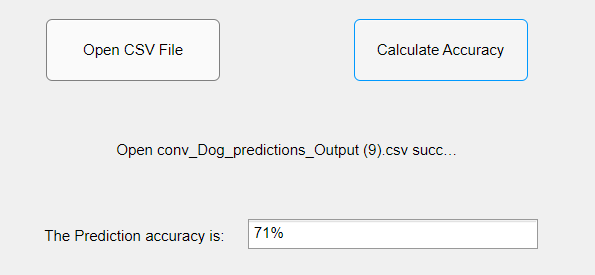

# 4. Compare results with [RVT paper](https://www.nature.com/articles/s41598-023-50063-x). Requirement: performance is better than VGG16: 70%

Our model accuracy is 71 %, which is nearly to VGG16 (RVT paper)

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link and GitHub weight link here.

1. Paper link 
(https://services.arxiv.org/html/submission/5720838/view#S5.F3)

2. GitHub weight Link
(https://github.com/niranjankumarnk/Project_1-convolutionNN-Dog_Dataset-/blob/main/model_conv_dog.pth)

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points


(4). Method  ---- 20 points

(5). Results ---- 20 points

     > = 70 % -->10 points
     < 50 % -->0 points
     >= 50 % & < 70% --> 0.5 point/percent
     

(6). Discussion - 10 points